<a href="https://colab.research.google.com/github/bonareri/Cryptocurrency-Price-Prediction-/blob/main/Random_Forest_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade xgboost scikit-learn

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set seaborn style for better visualization
sns.set_style("darkgrid")

In [3]:
# Define the coin and its ticker (only Bitcoin)
COINS = {
    "bitcoin": "BTC-USD"
}

def fetch_crypto_data(coin_id, ticker):
    print(f"Fetching data for {coin_id.upper()}...")

    end_date = datetime.today().strftime('%Y-%m-%d')
    start_date = (datetime.today() - timedelta(days=5*365)).strftime('%Y-%m-%d')

    crypto = yf.Ticker(ticker)
    df = crypto.history(start=start_date, end=end_date)

    if df.empty:
        print(f"Error: No historical data found for {coin_id}.")
        return None

    # Format data
    df.reset_index(inplace=True)
    df["Date"] = pd.to_datetime(df["Date"]).dt.strftime('%Y-%m-%d')

    # Keep relevant columns
    df = df[["Date", "Close", "High", "Low", "Open", "Volume"]]

    return df

def main():
    for coin_id, ticker in COINS.items():
        df = fetch_crypto_data(coin_id, ticker)
        if df is not None:
            filename = f"{coin_id}_prices_last_5_years.csv"
            df.to_csv(filename, index=False)
            print(f"Data saved to {filename}")

if __name__ == "__main__":
    main()

Fetching data for BITCOIN...
Data saved to bitcoin_prices_last_5_years.csv


In [4]:
#load csv
df = pd.read_csv('/content/bitcoin_prices_last_5_years.csv', parse_dates=['Date'])

In [5]:
df.head()

,Date,Close,High,Low,Open,Volume
0,2020-03-20,6198.778320,6844.261719,5865.781738,6191.653809,54442976103
1,2020-03-21,6185.066406,6378.135254,5932.823242,6206.521484,42494390880
2,2020-03-22,5830.254883,6359.697266,5823.713867,6185.558105,40099664740
3,2020-03-23,6416.314941,6443.934570,5785.004395,5831.374512,46491916000
4,2020-03-24,6734.803711,6789.022949,6411.066406,6436.642578,48221910672


In [6]:
df.tail()

,Date,Close,High,Low,Open,Volume
1820,2025-03-14,83969.101562,85263.289062,80797.562500,81066.992188,29588112414
1821,2025-03-15,84343.109375,84672.671875,83639.593750,83968.406250,13650491277
1822,2025-03-16,82579.687500,85051.601562,82017.906250,84333.320312,21330270174
1823,2025-03-17,84075.687500,84725.328125,82492.156250,82576.335938,25092785558
1824,2025-03-18,82718.500000,84075.718750,81179.992188,84075.718750,24095774594


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1825 non-null   datetime64[ns]
 1   Close   1825 non-null   float64       
 2   High    1825 non-null   float64       
 3   Low     1825 non-null   float64       
 4   Open    1825 non-null   float64       
 5   Volume  1825 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 85.7 KB


## Training on Data from 2020 to 2024 and Testing on data from 2025

## Data Preprocessing

### Feature engineering

In [8]:
def add_features(df):
    # Ensure data is sorted
    df = df.sort_values(by="Date")

    # Lag Features
    df["Close_Lag1"] = df["Close"].shift(1)
    df["Close_Lag2"] = df["Close"].shift(2)
    df["Close_Lag3"] = df["Close"].shift(3)

    # Moving Averages
    df["MA7"] = df["Close"].rolling(window=7).mean()
    df["MA14"] = df["Close"].rolling(window=14).mean()

    # Relative Strength Index (RSI)
    delta = df["Close"].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df["RSI"] = 100 - (100 / (1 + rs))

    # MACD (12-day EMA - 26-day EMA)
    df["EMA12"] = df["Close"].ewm(span=12, adjust=False).mean()
    df["EMA26"] = df["Close"].ewm(span=26, adjust=False).mean()
    df["MACD"] = df["EMA12"] - df["EMA26"]

    # Bollinger Bands
    df["BB_Middle"] = df["Close"].rolling(window=20).mean()
    df["BB_Upper"] = df["BB_Middle"] + 2 * df["Close"].rolling(window=20).std()
    df["BB_Lower"] = df["BB_Middle"] - 2 * df["Close"].rolling(window=20).std()

    # Drop NaN values created by rolling calculations
    df.dropna(inplace=True)

    return df

In [9]:
df = add_features(df)

# Check if new features exist
print(df.head())  # Print first few rows
print(df.info())  # Ensure new features are created

         Date        Close         High          Low         Open  \
19 2020-04-08  7334.098633  7356.223633  7153.305664  7179.283203   
20 2020-04-09  7302.089355  7341.448242  7179.094238  7337.966309   
21 2020-04-10  6865.493164  7303.815430  6802.475098  7303.815430   
22 2020-04-11  6859.083008  6926.069824  6789.920898  6867.440430   
23 2020-04-12  6971.091797  7119.947266  6811.078125  6858.067871   

         Volume   Close_Lag1   Close_Lag2   Close_Lag3          MA7  \
19  37563249549  7176.414551  7271.781250  6791.129395  6995.423270   
20  34815139178  7334.098633  7176.414551  7271.781250  7068.061105   
21  43622840992  7302.089355  7334.098633  7176.414551  7086.933384   
22  31222085946  6865.493164  7302.089355  7334.098633  7085.727051   
23  35759567632  6859.083008  6865.493164  7302.089355  7111.435965   

           MA14        RSI        EMA12        EMA26        MACD    BB_Middle  \
19  6699.550084  62.067177  6853.737439  6615.536633  238.200806  6591.999121

### Train-Test Split (Recent 2 Months for Testing)

In [10]:
# Find the most recent date in the dataset
latest_date = df["Date"].max()

# Define the cutoff date (most recent 2 months)
cutoff_date = latest_date - pd.DateOffset(months=2)

# Split the dataset
train_df = df[df["Date"] < cutoff_date]
test_df = df[df["Date"] >= cutoff_date]

# Print results
print(f"Training Data: {train_df.shape[0]} rows")
print(f"Testing Data: {test_df.shape[0]} rows")

# Display first few rows of training and testing sets
print("\nTrain Data Sample:")
print(train_df.head())

print("\nTest Data Sample:")
print(test_df.head())

Training Data: 1746 rows
Testing Data: 60 rows

Train Data Sample:
         Date        Close         High          Low         Open  \
19 2020-04-08  7334.098633  7356.223633  7153.305664  7179.283203   
20 2020-04-09  7302.089355  7341.448242  7179.094238  7337.966309   
21 2020-04-10  6865.493164  7303.815430  6802.475098  7303.815430   
22 2020-04-11  6859.083008  6926.069824  6789.920898  6867.440430   
23 2020-04-12  6971.091797  7119.947266  6811.078125  6858.067871   

         Volume   Close_Lag1   Close_Lag2   Close_Lag3          MA7  \
19  37563249549  7176.414551  7271.781250  6791.129395  6995.423270   
20  34815139178  7334.098633  7176.414551  7271.781250  7068.061105   
21  43622840992  7302.089355  7334.098633  7176.414551  7086.933384   
22  31222085946  6865.493164  7302.089355  7334.098633  7085.727051   
23  35759567632  6859.083008  6865.493164  7302.089355  7111.435965   

           MA14        RSI        EMA12        EMA26        MACD    BB_Middle  \
19  6699.5

### Select Features & Target Variable

In [11]:
# Define features (drop Date & Close, since Close is the target)
feature_columns = df.columns.difference(["Date", "Close"])
X_train = train_df[feature_columns]
y_train = train_df["Close"]
X_test = test_df[feature_columns]
y_test = test_df["Close"]

# Check the shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (1746, 16), y_train shape: (1746,)
X_test shape: (60, 16), y_test shape: (60,)


### Train a Random Forest Model

In [19]:
# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [20]:
# Predictions
y_pred = rf_model.predict(X_test)

In [22]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Compute RMSE
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared Score: {r2:.4f}")

Mean Absolute Error (MAE): 2474.29
Root Mean Squared Error (RMSE): 3564.90
R-squared Score: 0.7840


### Actual vs. Predicted Values

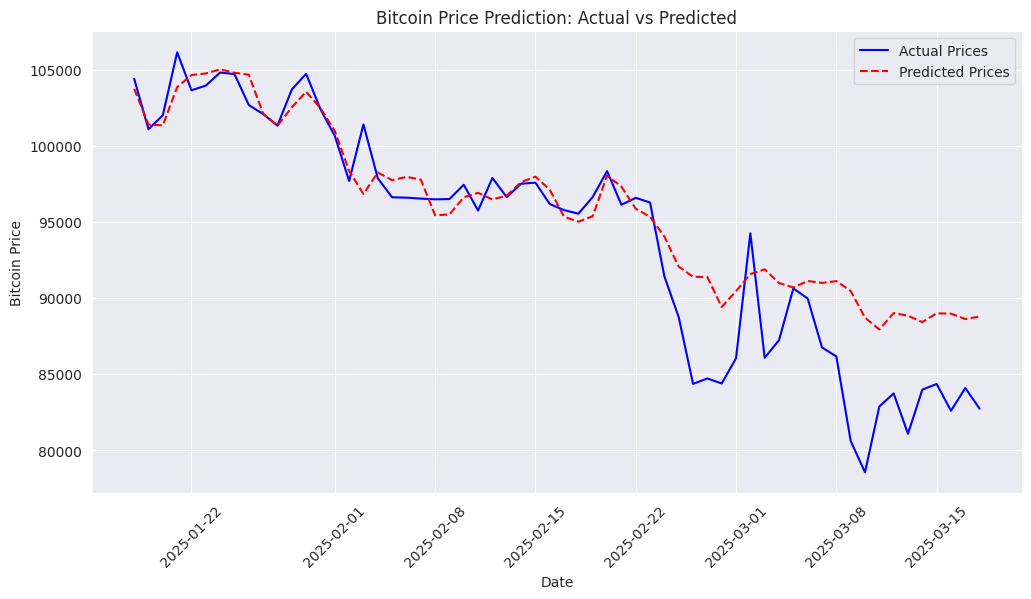

In [25]:
# Ensure test_data contains actual dates
test_data = df.iloc[-len(y_test):]  # Assuming df is your original dataset

plt.figure(figsize=(12, 6))

# Plot actual vs predicted prices
plt.plot(test_data["Date"], y_test.values, label="Actual Prices", color="blue", linestyle="-")
plt.plot(test_data["Date"], y_pred, label="Predicted Prices", color="red", linestyle="--")

plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.title("Bitcoin Price Prediction: Actual vs Predicted")
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.legend()
plt.show()

### XGBoost

In [12]:
# Define the XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)

# Train the model
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### predictions

In [13]:
y_pred_xgb = xgb_model.predict(X_test)

#### Evaluate model

In [14]:
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"XGBoost Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")
print(f"XGBoost R-squared Score: {r2_xgb:.4f}")

XGBoost Mean Absolute Error (MAE): 1923.29
XGBoost Root Mean Squared Error (RMSE): 2606.91
XGBoost R-squared Score: 0.8845


####  Predictions vs Actual

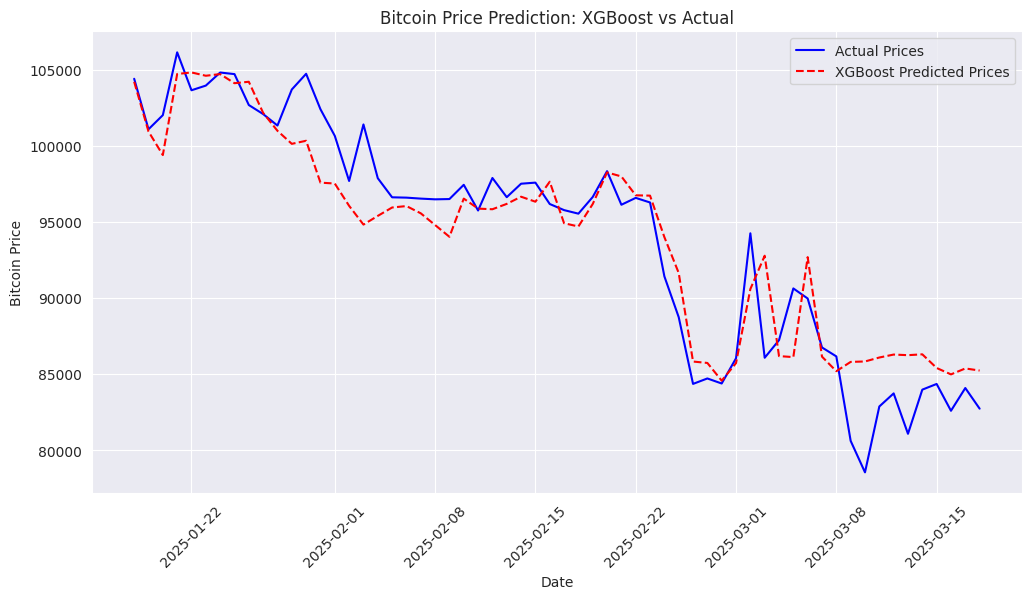

In [15]:
plt.figure(figsize=(12, 6))

# Use real dates from test_data
test_data = df.iloc[-len(y_test):]  # Ensure test_data contains actual dates

plt.plot(test_data["Date"], y_test.values, label="Actual Prices", color="blue", linestyle="-")
plt.plot(test_data["Date"], y_pred_xgb, label="XGBoost Predicted Prices", color="red", linestyle="--")

plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.title("Bitcoin Price Prediction: XGBoost vs Actual")
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Training on Data from 2014 to 2022 and Testing on data from 2023

In [ ]:
# Step 1: Sort the data by Date
df = df.sort_values(by="Date")

# Step 2: Define the split ratio (80% train, 20% test)
train_size = int(len(df) * 0.8)

# Split the data into train and test (maintain temporal order)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Step 3: Define features (Open, High, Low, Volume) and target variable (Close)
X_train, y_train = train[["Open", "High", "Low", "Volume"]], train["Close"]
X_test, y_test = test[["Open", "High", "Low", "Volume"]], test["Close"]

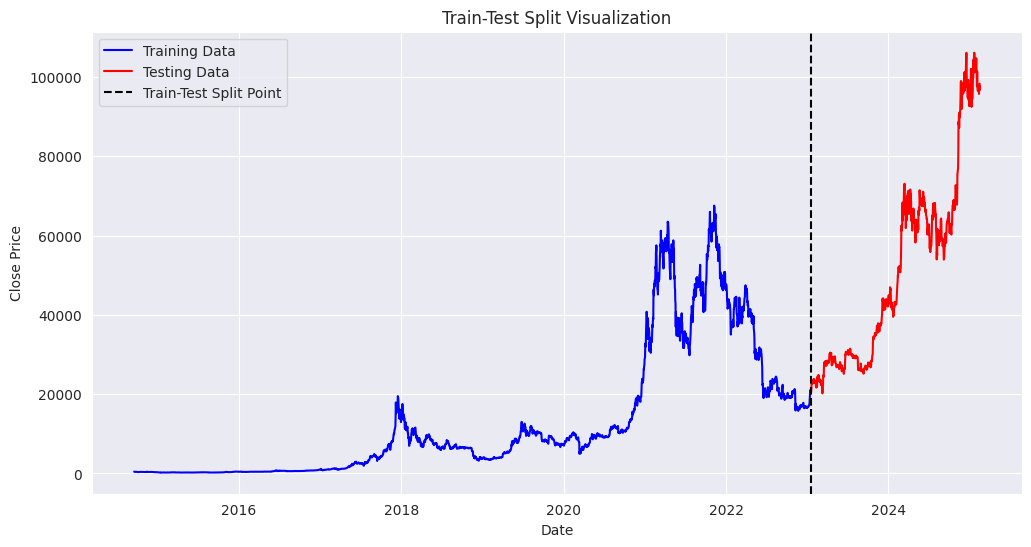

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(train["Date"], train["Close"], label="Training Data", color="blue")
plt.plot(test["Date"], test["Close"], label="Testing Data", color="red")
plt.axvline(x=test["Date"].iloc[0], color="black", linestyle="--", label="Train-Test Split Point")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Train-Test Split Visualization")
plt.legend()
plt.show()

In [ ]:
# Step 4: Min-Max Scaling for the features (but not the target variable)
scaler = MinMaxScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame for readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=["Open", "High", "Low", "Volume"])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=["Open", "High", "Low", "Volume"])

# Step 5: Check the shapes of the data
print(f"Train size: {X_train_scaled.shape}, Test size: {X_test_scaled.shape}")

Train size: (3043, 4), Test size: (761, 4)


## Modelling

### Random Forest

In [ ]:
rf_model = RandomForestRegressor(
    n_estimators=200,       # Number of decision trees in the forest
    max_depth=10,           # Maximum depth of each tree to prevent overfitting
    max_features='sqrt',    # Number of features to consider for splitting at each node
    random_state=42         # Ensures reproducibility
)

In [ ]:
# Fit the Random Forest model on the training data
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=200,
                      random_state=42)

In [ ]:
# Predict on the test data
y_pred = rf_model.predict(X_test_scaled)

In [ ]:
# Evaluate performance on the training set
y_train_pred = rf_model.predict(X_train_scaled)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)  # Compute RMSE manually
train_r2 = r2_score(y_train, y_train_pred)

# Evaluate performance on the testing set
y_test_pred = rf_model.predict(X_test_scaled)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)  # Compute RMSE manually
test_r2 = r2_score(y_test, y_test_pred)

# Print the performance metrics
# Print the performance metrics for the Random Forest model
print(f"Random Forest Training MAE: {train_mae:.2f}")
print(f"Random Forest Training RMSE: {train_rmse:.2f}")
print(f"Random Forest Training R²: {train_r2:.2f}\n")
print(f"Random Forest Testing MAE: {test_mae:.2f}")
print(f"Random Forest Testing RMSE: {test_rmse:.2f}")
print(f"Random Forest Testing R²: {test_r2:.2f}")

Random Forest Training MAE: 94.10
Random Forest Training RMSE: 185.00
Random Forest Training R²: 1.00

Random Forest Testing MAE: 4761.72
Random Forest Testing RMSE: 11494.35
Random Forest Testing R²: 0.77


### Learning Curves

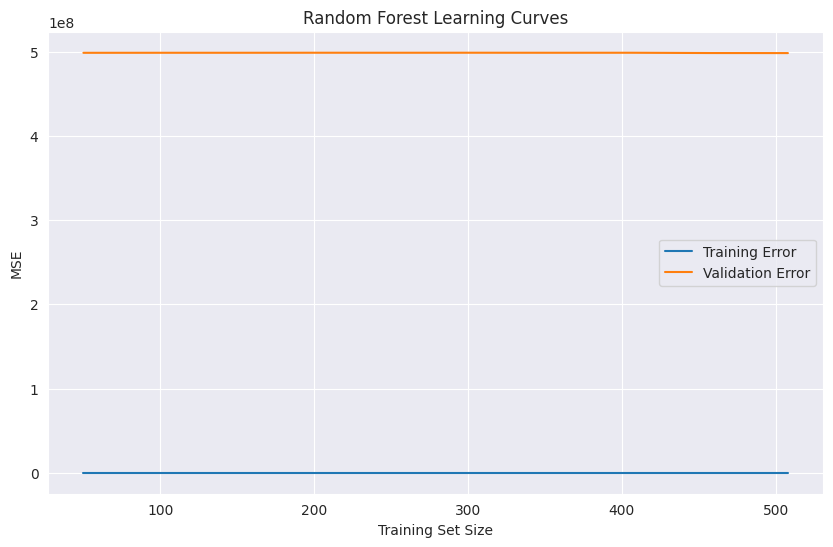

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, TimeSeriesSplit

# Define a TimeSeriesSplit for cross-validation on time-series data
tscv = TimeSeriesSplit(n_splits=5)

# Compute learning curves using negative MSE as scoring
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=rf_model,
    X=X_train_scaled,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=tscv,
    scoring='neg_mean_squared_error'
)

# Calculate the mean squared error for training and validation sets
train_errors_mean = -np.mean(train_scores, axis=1)
validation_errors_mean = -np.mean(validation_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors_mean, label='Training Error')
plt.plot(train_sizes, validation_errors_mean, label='Validation Error')
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.title('Random Forest Learning Curves')
plt.legend()
plt.show()

### 📊 Visualize Predictions

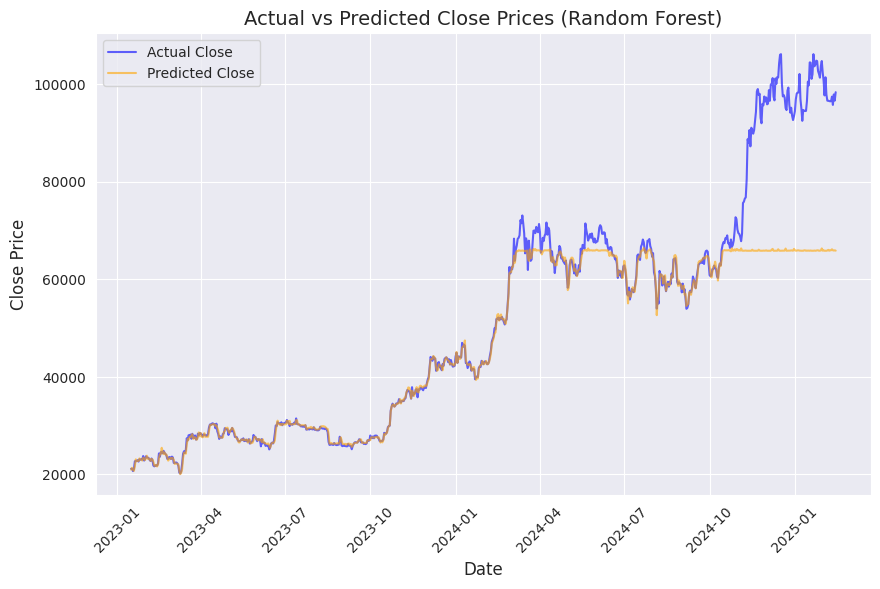

In [ ]:
# Step 6: Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))

# Ensure that the test data uses 'Date' as the index
plt.plot(test['Date'], y_test, label="Actual Close", color="blue", alpha=0.6)  # Using 'Date' for x-axis
plt.plot(test['Date'], y_pred, label="Predicted Close", color="orange", alpha=0.6)  # Using 'Date' for x-axis

# Chart formatting
plt.title("Actual vs Predicted Close Prices (Random Forest)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.xticks(rotation=45)  # Rotate the date labels for better readability
plt.legend()
plt.grid(True)
plt.show()

## XGBoost

In [ ]:
# Initialize the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=200,        # Number of boosting rounds (trees)
    learning_rate=0.05,      # Step size shrinkage to prevent overfitting
    max_depth=7,             # Maximum depth of each tree
    reg_lambda=0.5,          # L2 regularization (ridge)
    random_state=42
)

In [ ]:
# Train the model
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Make predictions on the test data
y_pred_xgb = xgb_model.predict(X_test_scaled)

In [ ]:
import numpy as np

# Evaluate performance on the training set
y_train_pred_xgb = xgb_model.predict(X_train_scaled)
train_mae_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
train_mse_xgb = mean_squared_error(y_train, y_train_pred_xgb)
train_rmse_xgb = np.sqrt(train_mse_xgb)  # Manual RMSE calculation
train_r2_xgb = r2_score(y_train, y_train_pred_xgb)

# Evaluate performance on the testing set
y_test_pred_xgb = xgb_model.predict(X_test_scaled)
test_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
test_mse_xgb = mean_squared_error(y_test, y_test_pred_xgb)
test_rmse_xgb = np.sqrt(test_mse_xgb)  # Manual RMSE calculation
test_r2_xgb = r2_score(y_test, y_test_pred_xgb)

# Print training performance metrics
print(f"XGBoost Training MAE: {train_mae_xgb:.2f}")
print(f"XGBoost Training RMSE: {train_rmse_xgb:.2f}")
print(f"XGBoost Training R²: {train_r2_xgb:.2f}\n")

# Print testing performance metrics
print(f"XGBoost Testing MAE: {test_mae_xgb:.2f}")
print(f"XGBoost Testing RMSE: {test_rmse_xgb:.2f}")
print(f"XGBoost Testing R²: {test_r2_xgb:.2f}")

XGBoost Training MAE: 86.35
XGBoost Training RMSE: 157.25
XGBoost Training R²: 1.00

XGBoost Testing MAE: 5357.49
XGBoost Testing RMSE: 12270.71
XGBoost Testing R²: 0.74


### Learning Curve Analysis

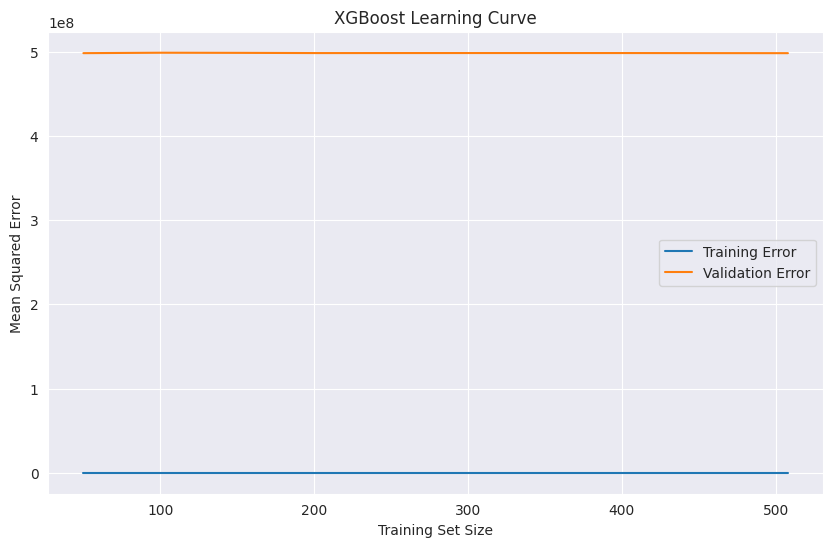

In [ ]:
import numpy as np
from sklearn.model_selection import learning_curve, TimeSeriesSplit

# Use TimeSeriesSplit for time series data
tscv = TimeSeriesSplit(n_splits=5)

# Compute learning curves using negative MSE as scoring
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=xgb_model,
    X=X_train_scaled,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=tscv,
    scoring='neg_mean_squared_error'
)

# Convert scores to positive MSE values
train_errors = -np.mean(train_scores, axis=1)
validation_errors = -np.mean(validation_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, label='Training Error')
plt.plot(train_sizes, validation_errors, label='Validation Error')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.title('XGBoost Learning Curve')
plt.legend()
plt.show()

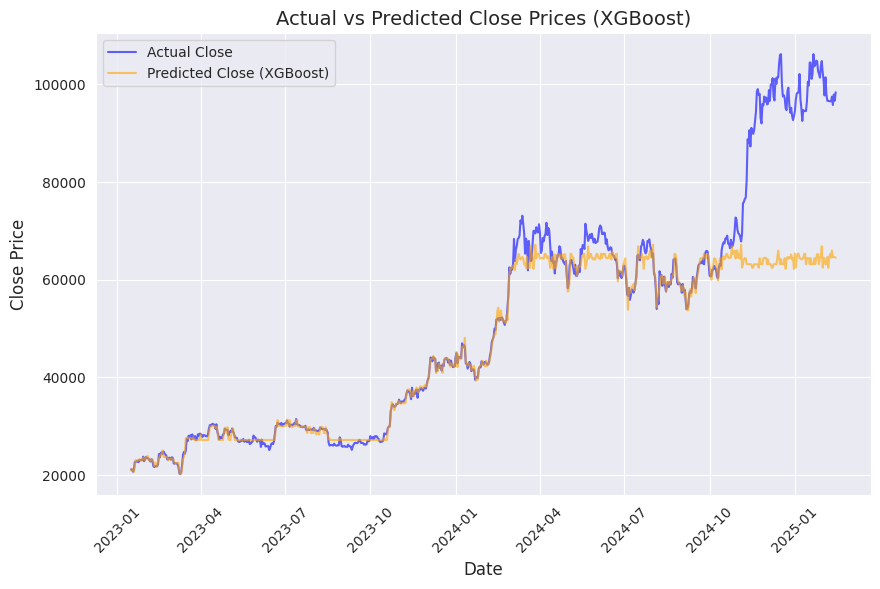

In [ ]:
# Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))

# Plot actual vs predicted for XGBoost
plt.plot(test['Date'], y_test, label="Actual Close", color="blue", alpha=0.6)
plt.plot(test['Date'], y_pred_xgb, label="Predicted Close (XGBoost)", color="orange", alpha=0.6)

# Chart formatting
plt.title("Actual vs Predicted Close Prices (XGBoost)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.xticks(rotation=45)  # Rotate the date labels for better readability
plt.legend()
plt.grid(True)
plt.show()

### Hyperparameter Tuning

In [ ]:
# Define the parameter distribution for Random Forest
param_dist_rf = {
    'n_estimators': [100, 200, 300, 500],                # Number of trees
    'max_depth': [None, 10, 20, 30, 50],                  # Max depth of trees
    'min_samples_split': [2, 5, 10],                       # Min samples to split internal nodes
    'min_samples_leaf': [1, 2, 4],                         # Min samples at leaf nodes
    'max_features': ['auto', 'sqrt', 'log2'],             # Number of features to consider for split
    'bootstrap': [True, False]                             # Whether bootstrap samples are used
}

In [ ]:
# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

In [ ]:
# Step 1: Setup RandomizedSearchCV
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist_rf,
                                      n_iter=50, cv=3, scoring='neg_mean_squared_error',
                                      n_jobs=-1, verbose=2, random_state=42)

In [ ]:
# Step 2: Fit the model using RandomizedSearchCV
random_search_rf.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
51 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [ ]:
# Step 3: Print the best parameters found
print(f"Best Parameters (Random Forest): {random_search_rf.best_params_}")

Best Parameters (Random Forest): {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}


In [ ]:
# Step 4: Evaluate the tuned model
best_rf_model = random_search_rf.best_estimator_

In [ ]:
# Make predictions with the tuned model
y_pred_rf = best_rf_model.predict(X_test_scaled)

In [ ]:
# Calculate evaluation metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf**0.5
r2_rf = r2_score(y_test, y_pred_rf)

In [ ]:
# Print evaluation metrics
print(f"Random Forest Tuned - Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"Random Forest Tuned - Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"Random Forest Tuned - Root Mean Squared Error (RMSE): {rmse_rf:.2f}")
print(f"Random Forest Tuned - R-squared (R2): {r2_rf:.2f}")

Random Forest Tuned - Mean Absolute Error (MAE): 4867.97
Random Forest Tuned - Mean Squared Error (MSE): 133886339.58
Random Forest Tuned - Root Mean Squared Error (RMSE): 11570.93
Random Forest Tuned - R-squared (R2): 0.77
